# DAT341 Programming assignment 5: spotting cars using convolutional neural networks

## Yahui Wu(15hrs)


## Tianshuo Xiao(15hrs)

## Group 21

### Preliminaries

Repeat the lectures (or at least the notebooks) about neural network basics and convolutional neural networks.

1.Make sure that Keras is installed. You can install by entering conda install tensorflow if using Anaconda. (The most recent version of Keras is bundled with the TensorFlow library.)

2.If you are installing via pip/pip3 rather than Anaconda, you will need to install h5py as well, if you'd like to be able to save your trained models.

3.Install the image processing library Pillow, which is needed by the Keras functions that load the images. (conda install pillow or pip3 install Pillow)

In [2]:
pip install tensorflow

  Using cached tensorflow-2.11.0-cp39-cp39-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.11.0-cp39-cp39-win_amd64.whl (266.3 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached protobuf-3.19.6-cp39-cp39-win_amd64.whl (895 kB)
  Using cached tensorflow_io_gcs_filesystem-0.30.0-cp39-cp39-win_amd64.whl (1.5 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached libclang-15.0.6.1-py2.py3-none-win_amd64.whl (23.2 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached termcolor-2.2.0-py3-none-any.whl (6.6 kB)
  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Using cached flatbuffers-23.1.21-py2.py3-none-any.whl (26 kB)
  Using cached grpcio-1.51.3-cp39-cp39-win_amd

In [5]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


### Introduction: Loading images from a directory

In this section, we'll see how we can a set of images stored in a directory. Your work here does not need to be included in the report.

First download the package containing the images here and unpack it. These images have been extracted from a dataset included in the PASCAL Visual Object Classes Challenge 2010 (VOC2010).

The structure of the directory is

a5_images

   train
   
      car   [800 images]
      
      other [800 images]
      
   validation
   
      car   [288 images]
      
      other [288 images]
      
so as you can see, the images have already been split into a training and a validation set, and each subset contains a separate directory for each of the two classes (car and other). The class other contains images of various objects.

Keras includes a function load_img to load a single image, but we'll use a more practical approach for this assignment.

We first declare an ImageDataGenerator. This is an object that defines how images should be converted into NumPy data. In our case, we add a parameter rescale; this means that the color values range from 0 to 1 instead of 0 to 255. (This transformation is similar to a scaler in scikit-learn and has a similar purpose.)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
data_gen = ImageDataGenerator(rescale=1.0/255)

Now, let's read the images in the training set. By calling flow_from_directory, we apply the ImageDataGenerator to transform the images stored in a directory. This will return a generator object that loads images, transforms them, and returns them in batches of a given size.

The parameters used here are:

    1.the location of the training images;

    2.target_size is for the size of the images: in our case, we'll resize them so that they are all 64x64 pixels;

    3.batch_size refers to the batch size we'll use when training;

    4.class_mode='binary' means that we'll treat the learning problem as a binary classification problem;

    5.classes is provided to make sure that other is coded as 0 and car as 1;

    6.seed is an arbitrary integer that initializes the random number generator for reproducibility;

    7.shuffle because we'd like the images to appear in a random order when training.

If you have a severe performance problem, you can resize the images to some size smaller than 64x64. This is likely to give you a slightly lower classification accuracy. (Conversely, if you have a high-end machine, you may consider increasing the image size.)

In [4]:
imgdir = 'a5_images' # or wherever you put them...
img_size = 64
batch_size = 32

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


Then I created a validation generator

In [5]:
validation_generator = data_gen.flow_from_directory(
        imgdir + '/validation', 
        target_size = (img_size, img_size), 
        batch_size = batch_size, 
        class_mode = "binary", 
        classes = ["other", "car"], 
        seed = 12345, 
        shuffle = True
)

Found 576 images belonging to 2 classes.


We'll take a look at a few images. We first read one batch from the generator. This will return a part of the training data: some images, and the corresponding labels (0 for other, 1 for car).

In [6]:
Xbatch, Ybatch = train_generator.next()

What is the form of the images in the batch? We take a look at the NumPy object that was returned. It is a four-dimensional NumPy array (formally, a four-dimensional tensor).

The dimensions are

    32, because there are 32 images in the batch
    64, for the height of each image
    64, for the width of each image
    3, because for each pixel we store the red, green, and blue value (a value between 0 and 1)

In [7]:
Xbatch.shape

(32, 64, 64, 3)

We'll take a look at the first instance. First, let's check whether this is a car or not. In my case, the label is 0 for the first instance, meaning that this is not a car. This doesn't have to be the case for you, because the images appear in a random order (shuffle=True).

In [8]:
Ybatch[4]

1.0

Draw the image using plt.imshow. (Assuming you have imported matplotlib.pyplot as plt.) As usual when plotting, you'll need to call plt.show() or plt.savefig(), or use an interactive notebook, to see something.

Hopefully, you can confirm from the image whether this is a car or not (and this should agree with Ybatch[0]). It might be a bit hard to see, because we resized the image to 64x64.

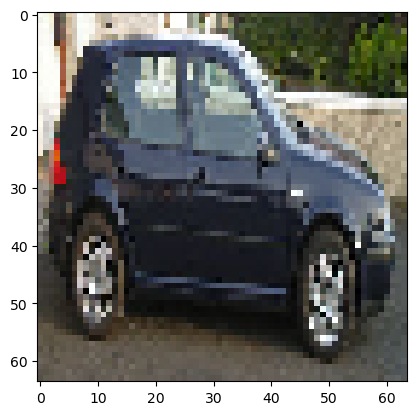

In [9]:
from matplotlib import pyplot as plt
plt.imshow(Xbatch[4]);

### Part 1: Training a convolutional neural network

In [41]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from matplotlib import pyplot as plt
import numpy as np

Write a function make_convnet that builds a convolutional neural network.

The input shape should be (img_size, img_size, 3), where img_size is the image size we defined above (such as 64), and 3 is for the red, green, and blue "channels" of the image. If you make use of the code we saw during the lecture, please note that this is a binary classification problem, so it's probably good to change the output layer and use another loss function.

Also remember to select a suitable optimizer.

In [11]:
def make_convnet(img_width, img_height, channels):#input: img_size, img_size, 3
    
    model = Sequential()
    
    # add convolutional layer with 32 convolution filters each with kernel size 3x3
    model.add(Conv2D(
        activation = "relu",
        input_shape = (img_width, img_height, channels),
        filters = 96,
        kernel_size = (3, 3),
        strides = (1, 1),
    ))
    
    # add max-pooling layer to downsize input
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    
    # add convolutional layer with 64 convolution filters each with kernel size 3x3
    model.add(Conv2D(activation = "relu", filters = 64, kernel_size = (3, 3)))
    
    # add max-pooling layer to downsize input
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    # add flatten layer to decrease the dimensions
    model.add(Flatten())
    
    # add dense layer to get fully connected and all relevant data
    model.add(Dense(activation = "relu", units = 128))
    
    # add dense layer
    model.add(Dropout(rate = 0.25, seed = 12345))
    
    # add dense layer as output layer with sigmoid activation function
    model.add(Dense(activation = "sigmoid", units = 1))

    # add the loss-function and compile
    model.compile(
        loss="binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
        metrics = ["accuracy"],
    )
    
    return model
    

In [12]:
model = make_convnet(img_size, img_size, 3)

Now we have everything that we need to train the CNN. Call fit to train the model.

In [13]:
fit_info = model.fit(train_generator,
                     epochs=20,
                     batch_size = batch_size,
                     verbose=1,
                     steps_per_epoch = len(train_generator),
                     validation_steps = len(validation_generator),
                     validation_data=validation_generator,
                    )

Epoch 1/20
50/50 [==============================] - 19s 345ms/step - loss: 0.6714 - accuracy: 0.5994 - val_loss: 0.6317 - val_accuracy: 0.6597
Epoch 2/20
50/50 [==============================] - 15s 295ms/step - loss: 0.6064 - accuracy: 0.6694 - val_loss: 0.5839 - val_accuracy: 0.7326
Epoch 3/20
50/50 [==============================] - 14s 285ms/step - loss: 0.5564 - accuracy: 0.7281 - val_loss: 0.5746 - val_accuracy: 0.7170
Epoch 4/20
50/50 [==============================] - 132s 3s/step - loss: 0.5172 - accuracy: 0.7500 - val_loss: 0.5711 - val_accuracy: 0.7101
Epoch 5/20
50/50 [==============================] - 15s 291ms/step - loss: 0.4781 - accuracy: 0.7819 - val_loss: 0.5677 - val_accuracy: 0.7031
Epoch 6/20
50/50 [==============================] - 14s 284ms/step - loss: 0.4792 - accuracy: 0.7650 - val_loss: 0.5538 - val_accuracy: 0.7309
Epoch 7/20
50/50 [==============================] - 15s 287ms/step - loss: 0.4339 - accuracy: 0.8050 - val_loss: 0.5138 - val_accuracy: 0.7569
E

Optionally, call your_cnn.save_weights(some_file_name) after training. This will save your weights to a file; you can recover them later using your_cnn.load_weights(the_same_file_name), so that you can run your CNN several times without having to re-train every time.

In [14]:
model.save_weights("weights/model_weights_p1")

In [15]:
fit_info.history

{'loss': [0.6713745594024658,
  0.6063961982727051,
  0.5564174652099609,
  0.5171681642532349,
  0.4780791997909546,
  0.47921648621559143,
  0.4338949918746948,
  0.4087402820587158,
  0.37461602687835693,
  0.3625594675540924,
  0.3545481562614441,
  0.34110724925994873,
  0.3233621120452881,
  0.3033622205257416,
  0.2916716933250427,
  0.2786356210708618,
  0.2788080871105194,
  0.2507740259170532,
  0.24536317586898804,
  0.2303883135318756],
 'accuracy': [0.5993750095367432,
  0.6693750023841858,
  0.7281249761581421,
  0.75,
  0.7818750143051147,
  0.7649999856948853,
  0.8050000071525574,
  0.8293750286102295,
  0.8462499976158142,
  0.8556249737739563,
  0.8543750047683716,
  0.8693749904632568,
  0.8662499785423279,
  0.8887500166893005,
  0.8899999856948853,
  0.8981249928474426,
  0.8918750286102295,
  0.9137499928474426,
  0.9081249833106995,
  0.9243749976158142],
 'val_loss': [0.6317090392112732,
  0.5838696360588074,
  0.5745702981948853,
  0.5711305737495422,
  0.5677

Plot the training and validation loss for each epoch. Also plot the training and validation accuracies in another plot.

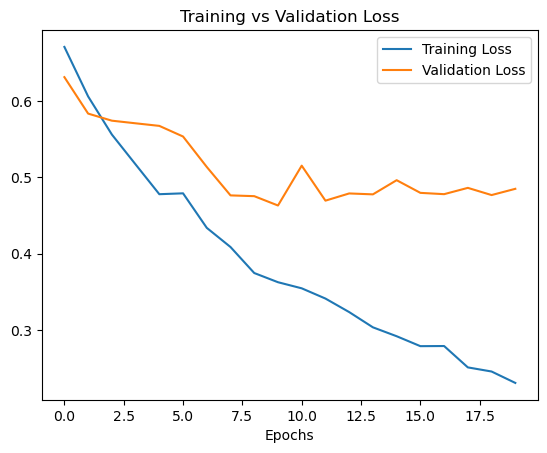

In [18]:
plt.plot(fit_info.history["loss"], label='Training Loss')
plt.plot(fit_info.history["val_loss"], label='Validation Loss')
plt.xlabel('Epochs')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

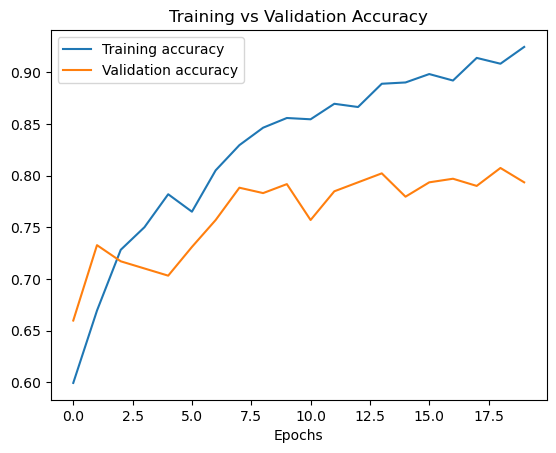

In [19]:
plt.plot(fit_info.history["accuracy"], label='Training accuracy')
plt.plot(fit_info.history["val_accuracy"], label='Validation accuracy')
plt.xlabel('Epochs')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

If you need to run the model on a dataset that you access via a generator, you can use evaluate. The loss function and the accuracy will be computed. (As you can see, these values are the same as you got in the last epoch when training.)

In [20]:
score = model.evaluate(
    validation_generator, 
    steps = len(validation_generator),
    verbose = 0
)

In [21]:
print(f"Test loss: {score[0]}, Test accuracy {score[1]}")

Test loss: 0.48513638973236084, Test accuracy 0.7934027910232544


We plot the training and validation loss for each epoch and it is clear that there is overfitting when comes loss. The loss in the validation set remains approximately constant but with some fluctuations. The loss in the training set decreases consistently. In our accuracy plotted, the accuracy of the training set converges to 1. Although the accuracy of the validation set has improved, it finally converges to 78%, from which we can find the existence of overfitting.

### Part 2: Data augmentation

Most likely, unless you applied early stopping very aggressively, you saw some overfitting in your solution.

One approach to reducing the risk of overfitting to the training set is to apply data augmentation. This means that we create additional training instances by applying different types of modifications to the existing training images.

Take a look at the documentation of ImageDataGenerator. Several of the optional parameters enable different types of data augmentation, such as rotation, mirroring, and changing the colors.

Make a new ImageDataGenerator that applies data augmentation to the training images.

In [22]:
data_gen_aug = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )# we changed some parameters

Make a new training data generator that uses the new ImageDataGenerator, instead of the generator data_gen we originally used, and retrain your model. (Note: The generator for reading the validation data should not use data augumentation.)

In [23]:
train_generator_aug = data_gen_aug.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [24]:
model_aug = make_convnet(img_size, img_size, 3)

In [25]:
fit_info_aug = model_aug.fit(train_generator_aug,
                     epochs=20,
                     batch_size = batch_size,
                     verbose=1,
                     steps_per_epoch = len(train_generator_aug),
                     validation_steps = len(validation_generator),
                     validation_data=validation_generator)

Epoch 1/20
50/50 [==============================] - 25s 454ms/step - loss: 0.6882 - accuracy: 0.5456 - val_loss: 0.6708 - val_accuracy: 0.5816
Epoch 2/20
50/50 [==============================] - 21s 421ms/step - loss: 0.6558 - accuracy: 0.6263 - val_loss: 0.6468 - val_accuracy: 0.6337
Epoch 3/20
50/50 [==============================] - 22s 434ms/step - loss: 0.6201 - accuracy: 0.6644 - val_loss: 0.6196 - val_accuracy: 0.6736
Epoch 4/20
50/50 [==============================] - 22s 443ms/step - loss: 0.6150 - accuracy: 0.6712 - val_loss: 0.6083 - val_accuracy: 0.6771
Epoch 5/20
50/50 [==============================] - 22s 431ms/step - loss: 0.6073 - accuracy: 0.6794 - val_loss: 0.5904 - val_accuracy: 0.7101
Epoch 6/20
50/50 [==============================] - 22s 436ms/step - loss: 0.5844 - accuracy: 0.7056 - val_loss: 0.6006 - val_accuracy: 0.6840
Epoch 7/20
50/50 [==============================] - 23s 454ms/step - loss: 0.5723 - accuracy: 0.6944 - val_loss: 0.5809 - val_accuracy: 0.7014

In [26]:
model_aug.save_weights("weights/model_weights_p2")

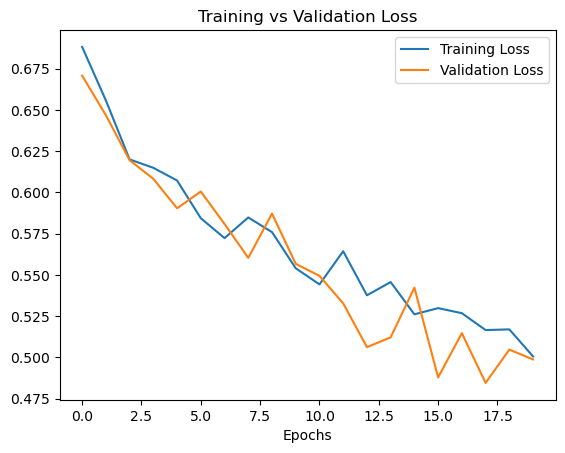

In [27]:
plt.plot(fit_info_aug.history["loss"], label='Training Loss')
plt.plot(fit_info_aug.history["val_loss"], label='Validation Loss')
plt.xlabel('Epochs')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

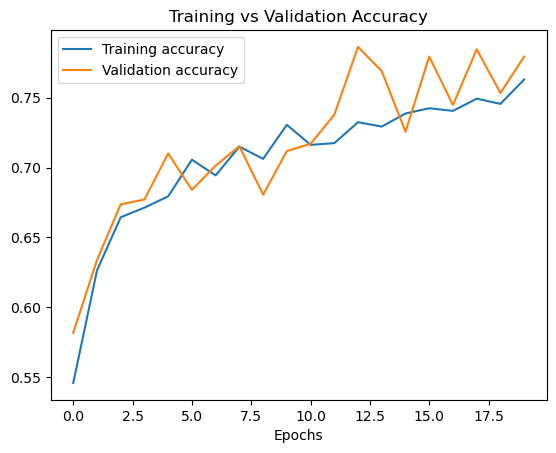

In [28]:
plt.plot(fit_info_aug.history["accuracy"], label='Training accuracy')
plt.plot(fit_info_aug.history["val_accuracy"], label='Validation accuracy')
plt.xlabel('Epochs')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [29]:
score = model_aug.evaluate(
    validation_generator, 
    steps = len(validation_generator),
    verbose = 0
)

In [30]:
print(f"Test loss: {score[0]}, Test accuracy {score[1]}")

Test loss: 0.49882152676582336, Test accuracy 0.7795138955116272


As we can see from the curves above, the validation accuracy is around 78%, but the overfitting of the training set is much stronger than when using the image data generator without data augmentation. The validation accuracy is relatively high in most of the epochs.

### Interlude: Applying a pre-trained convolutional neural network

One of the most famous image databases used in computer vision is called ImageNet. It contains a very large number of categories and an even larger number of example images for each category. This is one of the standard benchmarks in the field.

Several CNNs that have been trained on ImageNet have been released to the public, and Keras includes several of them. In this exercise, we'll use the model called VGG-16, which was developed by a group at the university of Oxford. Here is a description of VGG-16.

VGG-16

We use the built-in function in Keras to build the VGG-16 model and load the weights. Here, means that we use the pre-trained weights, and that we use the full classification model.weights='imagenet'include_top=True

The first time you execute this code, the VGG-16 model will be downloaded. (It will then be stored on your disk for future use.)

In [31]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

vggmodel = applications.VGG16(weights='imagenet', include_top=True)

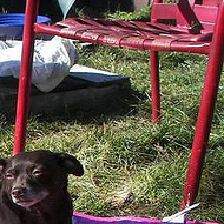

In [32]:
img = load_img(f'{imgdir}/train/other/0003.jpg', target_size=(224,224))
img

To demonstrate the VGG-16 model as a classifier, we will now classify an example image.

Carry out the following steps:

    1.Select any image, for instance one from your training or validation data. Take a look at the image so that you see what it depicts.
    
    2.Load the image using . The 224x224 target size is required because this is the standard input size of the VGG-16 model when we use it as a classifier. This will return an object.load_img(the_file_name, target_size=(224,224))Image
    
    3.Convert the image into a 3-dimensional NumPy array using .img_to_array
    
    4.Process the image using the Keras function . This function returns a new NumPy array. This step carries out some preprocessing of the image necessary for VGG-16. (This is different from dividing by 255 as we did previously.)preprocess_input
    
    5.Finally, reshape the image array into a four-dimensional array. The reason for reshaping is that the function in Keras operates on "batches" of images. Even if we are classifying just a single image, we need to put it into an array.
    
    your_image = your_image.reshape(1, 224, 224, 3)
    predict

In [33]:
img_array = img_to_array(img)
img_array = preprocess_input(img_array)
img_array = img_array.reshape(1, 224, 224, 3)

Predict the class probabilities for this image, using . This will result in a 1 x 1000 matrix. There are 1000 columns because the VGG-16 classifier uses 1000 ImageNet classes.vggmodel.predict

In [34]:
img_pre = vggmodel.predict(img_array)

1/1 [==============================] - 1s 852ms/step


In [35]:
img_result = decode_predictions(img_pre)
img_result

[[('n02093256', 'Staffordshire_bullterrier', 0.2838164),
  ('n02104365', 'schipperke', 0.15208441),
  ('n02105412', 'kelpie', 0.08643364),
  ('n02099712', 'Labrador_retriever', 0.08014996),
  ('n02110958', 'pug', 0.05764634)]]

We have chosen a special item for verification and prediction makes some sense to distinguish specific items in the image. The network returns the top 5 categories with the highest probability. We see that the item in the picture is a cow or a dog, but it is difficult to determine which species it is.

### Part 3: Using VGG-16 as a feature extractor

Let's return to the problem of finding images of cars.

Since we just have 1,600 training images, the CNN we trained earlier wasn't fantastically successful. We'll now take a different approach, inspired by the paper by Razavian et al. (2014): we'll use the VGG-16 model as a feature extractor: we'll apply the convolutional part of the VGG-16 model to our images, and use this output as the input of our own classifier. This solution is an example of transfer learning, which means that we leverage the knowledge stored in a pre-trained model and apply it to our specific task.

To get started, we load the VGG-16 model once more. Please note that the parameters are a bit different this time:

    1.include_top=False because we won't use the highest layers in the ImageNet classifier. Instead, we'll train our own classifier.

    2.We specify an that overrides the 224x224 size that is the default size used by VGG-16. For the purpose of comparing to our previous results, we'll use the same size as in our first CNN classifier.input_shape

In [36]:
feature_extractor = applications.VGG16(include_top=False,
                                       weights='imagenet',
                                       input_shape=(img_size, img_size, 3))

Before reading the images, we need to create a new that applies (the preprocessing required for VGG-16) to the images that it processes.ImageDataGeneratorpreprocess_input

In [37]:
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

Now, write a function that carries out the following steps:create_vgg16_features

First, make a generator that reads a given directory (either the train or the validation directory). You should use , so that the preprocessing is done correctly. [Hint: for reasons that will become clearer a bit later, if you set in the generator, you will make your life easier later on.]vgg_data_genshuffle=False

Second, apply the VGG-16 model to the generator (). This will return a four-dimensional NumPy array.feature_extractor.predict(...)
Third, save this NumPy array into a file. Make sure that you don't use the same file name for the training part and the validation part. The option means that we are writing the data into a binary format, not a text format.

    with open(SOME_FILE_NAME, 'wb') as f:

      np.save(f, cnn_features)

    'wb'

In [38]:
def create_vgg16_features(directory, SOME_FILE_NAME):
    generator = vgg_data_gen.flow_from_directory(
        imgdir + directory,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=False)
    #To keep things simple, the following helper function may be used to create the output labels, assuming that the dataset has a size of n. 
    #This function assumes that all the other instances come before the car instances. (This is the reason we set shuffle=False in the generator above.)
    cnn_features = feature_extractor.predict(generator)
    
    with open(SOME_FILE_NAME, 'wb') as f:
        np.save(f, cnn_features)
    

Call this function twice, once for the training part and once for the validation part. This process should take a few minutes, depending on the performance of your machine.

In [39]:
#training part 
create_vgg16_features("/train","vgg16_train.txt")

Found 1600 images belonging to 2 classes.
50/50 [==============================] - 24s 470ms/step


In [40]:
#validation part
create_vgg16_features("/validation","vgg16_val.txt")

Found 576 images belonging to 2 classes.
18/18 [==============================] - 8s 441ms/step


Finally, write a function that reads the two files that you created, trains a classifier on the training set, and evaluates on the validation set. To read the files, you can write something like this:train_on_cnnfeatures

with open(SOME_FILE_NAME, 'rb') as f:
    the_data = np.load(f)
Here, means that we are reading in a binary format.'rb'

In [42]:
def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))

We use use Keras here: If you use Keras, your first layer needs to be a Flatten layer, to convert the outputs from the last VGG-16 pooling layer into straight vectors.

In [44]:
def make_convnet_new (img_width, img_height, channels):
    
    model = Sequential()
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    
    model.add(Dropout(rate = 0.25, seed = 12345))
    
    model.add(Dense(activation = "sigmoid", units = 1))
    
    opt = optimizers.SGD(learning_rate = 0.001, momentum = 0.9)
    
    #add the loss function and compile
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [45]:
def train_on_cnnfeatures():
    with open('vgg16_train.txt', 'rb') as f:
        train_data = np.load(f)
    
    with open('vgg16_val.txt', 'rb') as f:
        val_data = np.load(f)
    
    train_label = get_labels(train_data.shape[0])
    val_label = get_labels(val_data.shape[0])
    
    model = make_convnet_new (img_size, img_size, 3)
    
    return model, model.fit(train_data,
                             train_label,
                             batch_size = batch_size,
                             epochs=20,
                             validation_data=(val_data, val_label)
    )

In [1]:
def train_on_cnnfeatures2(): #other try
    with open('vgg16_train.txt', 'rb') as f:
        train_data = np.load(f)
    
    with open('vgg16_val.txt', 'rb') as f:
        val_data = np.load(f)
    
    train_label = get_labels(train_data.shape[0])
    val_label = get_labels(val_data.shape[0])
    
    model = make_convnet_new (img_size, img_size, 3)
    
    fit_info = model.fit(train_data,
                             train_label,
                             batch_size = batch_size,
                             epochs=20,
                             validation_data=(val_data, val_label)
    )
    
    return model, fit_info

In [138]:
model, fit_info = train_on_cnnfeatures2()

Epoch 1/20
50/50 [==============================] - 2s 18ms/step - loss: 2.2418 - accuracy: 0.8400 - val_loss: 0.4251 - val_accuracy: 0.8559
Epoch 2/20
50/50 [==============================] - 1s 11ms/step - loss: 0.1407 - accuracy: 0.9463 - val_loss: 0.3738 - val_accuracy: 0.8924
Epoch 3/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0466 - accuracy: 0.9800 - val_loss: 0.3575 - val_accuracy: 0.9010
Epoch 4/20
50/50 [==============================] - 1s 13ms/step - loss: 0.0218 - accuracy: 0.9956 - val_loss: 0.3794 - val_accuracy: 0.8941
Epoch 5/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0127 - accuracy: 0.9975 - val_loss: 0.3898 - val_accuracy: 0.8993
Epoch 6/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0087 - accuracy: 0.9987 - val_loss: 0.4026 - val_accuracy: 0.8976
Epoch 7/20
50/50 [==============================] - 0s 10ms/step - loss: 0.0064 - accuracy: 0.9994 - val_loss: 0.4202 - val_accuracy: 0.8976
Epoch 8/20
50/5

In [46]:
model, fit_info = train_on_cnnfeatures()

Epoch 1/20
50/50 [==============================] - 2s 15ms/step - loss: 2.0429 - accuracy: 0.8500 - val_loss: 0.5468 - val_accuracy: 0.8993
Epoch 2/20
50/50 [==============================] - 0s 8ms/step - loss: 0.2258 - accuracy: 0.9337 - val_loss: 0.3379 - val_accuracy: 0.9080
Epoch 3/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0990 - accuracy: 0.9606 - val_loss: 0.3667 - val_accuracy: 0.9045
Epoch 4/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0538 - accuracy: 0.9812 - val_loss: 0.3675 - val_accuracy: 0.9097
Epoch 5/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0359 - accuracy: 0.9912 - val_loss: 0.3737 - val_accuracy: 0.9097
Epoch 6/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0258 - accuracy: 0.9925 - val_loss: 0.3912 - val_accuracy: 0.9132
Epoch 7/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0234 - accuracy: 0.9931 - val_loss: 0.4296 - val_accuracy: 0.9097
Epoch 8/20
50/50 

In [47]:
model.save_weights("weights/model_weights_p3")

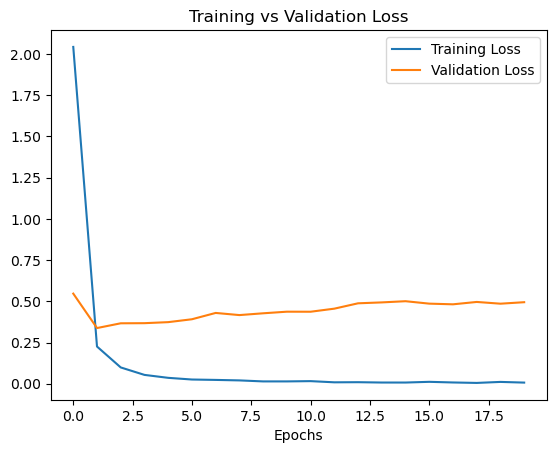

In [48]:
plt.plot(fit_info.history["loss"], label='Training Loss')
plt.plot(fit_info.history["val_loss"], label='Validation Loss')
plt.xlabel('Epochs')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

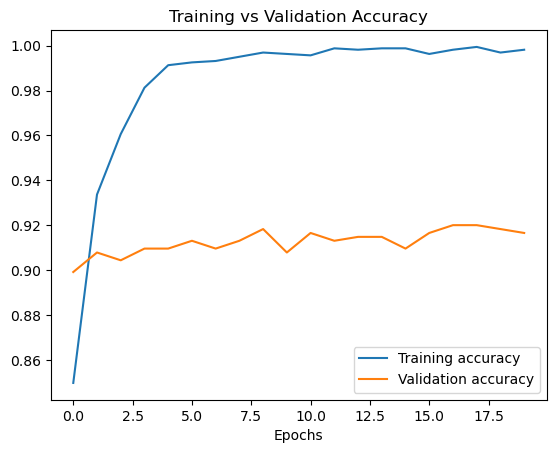

In [50]:
plt.plot(fit_info.history["accuracy"], label='Training accuracy')
plt.plot(fit_info.history["val_accuracy"], label='Validation accuracy')
plt.xlabel('Epochs')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

We see an accuracy that is significantly higher than when you trained your standalone CNN previously and the accuracy is 91.67%.

In VGG, three 3x3 convolutional kernels are used instead of 7x7 convolutional kernels, and two 3x3 convolutional kernels are used instead of 5*5 convolutional kernels. The main purpose of this is to improve the depth of the network while ensuring that it has the same perceptual field, which improves the effectiveness of the neural network to some extent.VGG has a much larger dataset. It use the pre-trained layers and only the final layers are replaced with new layers that are specific to the task at hand. This allows the model to leverage the powerful feature extraction capabilities of VGG-16, while still adapting to the specific features of the new dataset.

In addition, more layers in VGG16 usually mean extracting higher-level features, i.e. not just simple shapes such as edges and color contrasts, but also features like the individual components of the car, the external environment, etc. Compared with the previous CNN model, the correct rate of validation is significantly higher, reaching 91.67%.



### Visualizing the learned features

The first convolutional layer represents the most low-level patterns that the model looks for in images. We will now visualize these features in the VGG-16 model. (You can also repeat the exercise using your own original model, but because we have so little data, the features in this model may look less like interpretable patterns.)

We get the weights in this convolutional layer. This is a four-dimensional NumPy tensor: width x height x colors x number of convolutions.

In [51]:
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 64)

We create a utility function that will help us visualize the patterns extracted by the first convolutional layer.

This function takes three inputs: the layer's weight tensor (from the step above), a number referring to which convolutional filter we are considering (0-63), and finally a boolean (True/False) value that says whether we want to see the positive or the negative part of this filter. (That is, if positive=True, we see the patterns which enable this "feature"; if it is False, we see the patterns that disable it.)

In [52]:
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k

In [53]:
positive_kernel_images = [kernel_image(first_layer_weights, x, True) for x in range(64)]
negative_kernel_images = [kernel_image(first_layer_weights, x, False) for x in range(64)]

Visualize some of the patterns used by the first convolutional layer.

FILTER No.0


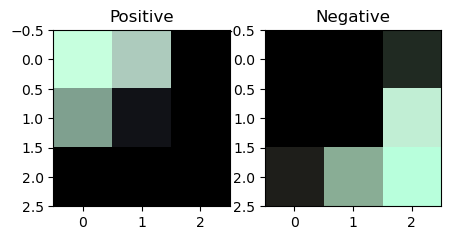

FILTER No.2


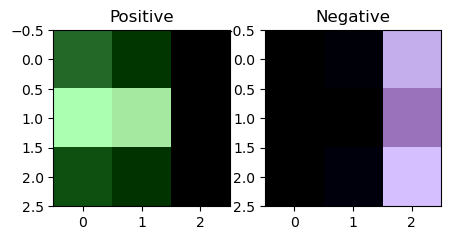

FILTER No.4


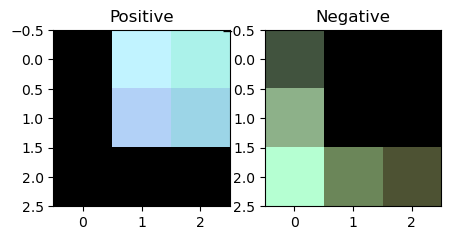

FILTER No.6


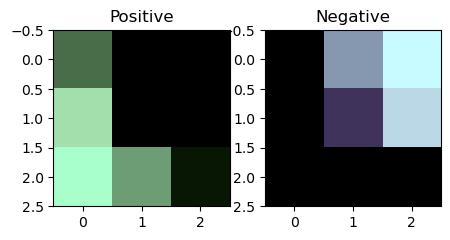

FILTER No.8


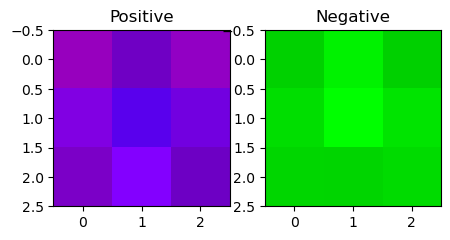

FILTER No.10


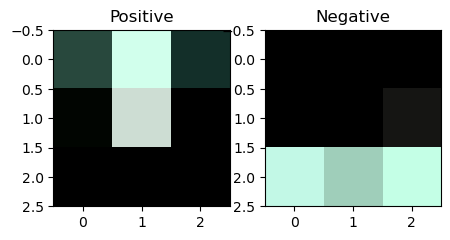

FILTER No.12


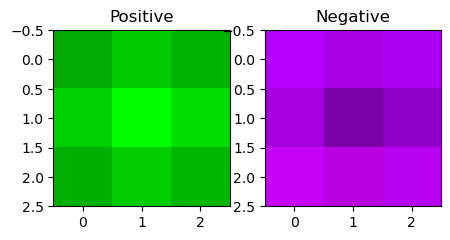

FILTER No.14


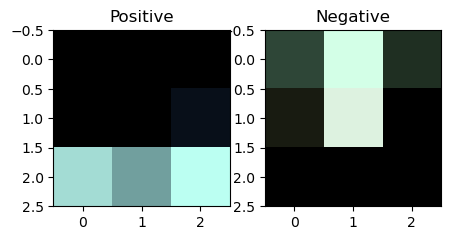

FILTER No.16


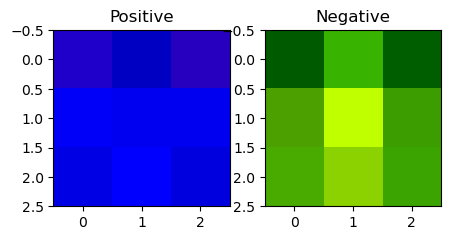

FILTER No.18


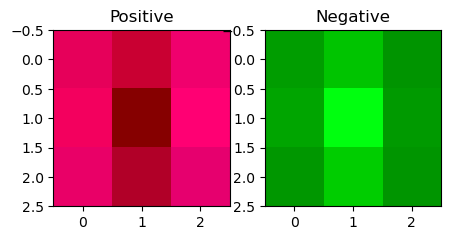

In [63]:
for i in range(0, 20, 2):
    print(f"FILTER No.{i}")
    
    fig, axs = plt.subplots(1, 2, figsize=(5, 5))
    axs[0].imshow(positive_kernel_images[i])
    axs[0].set_title("Positive")
    
    axs[1].imshow(negative_kernel_images[i])
    axs[1].set_title("Negative")
    
    plt.show()

In the images shown above, we find that the features of some images can be clearly distinguished, such as No.0, which has a clear pixel gradient change, but it is difficult to distinguish for other kernels.